In [1]:
!pip install pyspark

     -------------------------------------- 281.4/281.4 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 199.7/199.7 kB 12.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d95a9d8499eade1e8b9e46113d88e38d11b69c9e2113d5ba6c8e88de181fa1a5
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\51\c8\18\298a4ced8ebb3ab8a7d26a7198c0cc7035abb906bde94a4c4b
Successfully built pyspark


#                                           
                                                            Houda BEL KORCHI
                                 Les validations télé-billettiques des cartes de transport en Ile de France

In [1]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName('First One').getOrCreate()

In [2]:
spark

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
spark = SparkSession.builder.appName("Lecture CSV").getOrCreate()

df1 = spark.read.csv("validat_2eme.csv", header=True, inferSchema=True,sep=';')


In [4]:
df1 = df1.filter((F.col('categorie_titre') == "NAVIGO") | (F.col('categorie_titre') == "IMAGINE R"))
df1.show(10)


+-------------------+--------------+-------------+---------------+--------------------+---------------+---------------+-------+
|               JOUR|CODE_STIF_TRNS|CODE_STIF_RES|CODE_STIF_LIGNE|       LIBELLE_LIGNE|ID_GROUPOFLINES|CATEGORIE_TITRE|NB_VALD|
+-------------------+--------------+-------------+---------------+--------------------+---------------+---------------+-------+
|2022-04-13 00:00:00|           100|          987|            772|                 N41|         A01262|      IMAGINE R|     10|
|2022-04-13 00:00:00|           100|          987|            775|                 N01|         A01264|      IMAGINE R|    147|
|2022-04-13 00:00:00|           100|          987|            780|                 N11|         A01266|      IMAGINE R|     78|
|2022-04-13 00:00:00|           100|          987|            783|                 N14|         A01269|         NAVIGO|    442|
|2022-04-13 00:00:00|           100|          987|            784|                 N13|         A01270| 

# Visualisation du trafic dans une station

In [5]:
from pyspark.sql.functions import sum

resultats = (df1
             .groupBy('LIBELLE_LIGNE')
             .agg(sum('NB_VALD').alias('NB_VALD'))
             .selectExpr('LIBELLE_LIGNE', 'NB_VALD')
             .orderBy('NB_VALD', ascending=False)
             .limit(4))

resultats.show()


+-------------+-------+
|LIBELLE_LIGNE|NB_VALD|
+-------------+-------+
|          T3a|7138726|
|           T2|6370982|
|          T3b|5515061|
|           T1|2827377|
+-------------+-------+



In [6]:
df1.filter(F.col('LIBELLE_LIGNE') == "T3a").show(5)
     

+-------------------+--------------+-------------+---------------+-------------+---------------+---------------+-------+
|               JOUR|CODE_STIF_TRNS|CODE_STIF_RES|CODE_STIF_LIGNE|LIBELLE_LIGNE|ID_GROUPOFLINES|CATEGORIE_TITRE|NB_VALD|
+-------------------+--------------+-------------+---------------+-------------+---------------+---------------+-------+
|2022-04-14 00:00:00|           100|          112|             13|          T3a|         A01193|         NAVIGO|  73584|
|2022-05-13 00:00:00|           100|          112|             13|          T3a|         A01193|      IMAGINE R|  28303|
|2022-04-22 00:00:00|           100|          112|             13|          T3a|         A01193|      IMAGINE R|  28330|
|2022-05-29 00:00:00|           100|          112|             13|          T3a|         A01193|      IMAGINE R|  10366|
|2022-05-30 00:00:00|           100|          112|             13|          T3a|         A01193|      IMAGINE R|  22648|
+-------------------+-----------

In [7]:
(df1
 .filter(F.col('LIBELLE_LIGNE') == "T3a")
 .groupby('CODE_STIF_LIGNE')
 .agg(F.sum('nb_vald').alias('Total_Validation'))).show()

+---------------+----------------+
|CODE_STIF_LIGNE|Total_Validation|
+---------------+----------------+
|             13|         7138726|
+---------------+----------------+



In [8]:
(df1
    .filter(F.col('LIBELLE_LIGNE') == "T3a")
    .groupby('jour', 'categorie_titre')
    .agg(F.sum('nb_vald').alias('nb_vald'))).show(5)

+-------------------+---------------+-------+
|               jour|categorie_titre|nb_vald|
+-------------------+---------------+-------+
|2022-06-24 00:00:00|      IMAGINE R|  21787|
|2022-05-30 00:00:00|         NAVIGO|  63394|
|2022-06-14 00:00:00|         NAVIGO|  74906|
|2022-04-14 00:00:00|         NAVIGO|  73584|
|2022-05-16 00:00:00|         NAVIGO|  71017|
+-------------------+---------------+-------+
only showing top 5 rows



<AxesSubplot:xlabel='jour'>

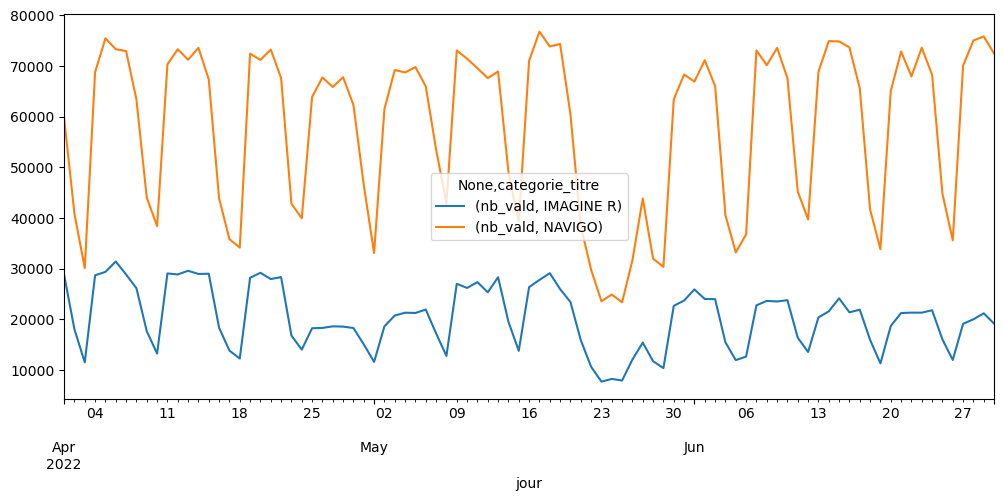

In [9]:
import seaborn as sns

(df1
    .filter(F.col('LIBELLE_LIGNE') == "T3a")
    .groupby('jour', 'categorie_titre')
    .agg(F.sum('nb_vald').alias('nb_vald'))).toPandas().set_index(['jour', 'categorie_titre']).unstack(1).plot(figsize=(12, 5))
     

In [11]:
from pyspark.sql.functions import dayofweek, sum, col, lit, concat, round
from pyspark.sql.window import Window

A=(df1
 .withColumn('day_week', F.dayofweek('jour'))
 .groupby('day_week')
 .agg(F.sum('nb_vald').alias('Total_Validation'))
 .orderBy(F.desc('Total_Validation'))
 .withColumn('Proportion',concat(F.round(F.col('Total_Validation')/F.sum('Total_Validation').over(Window.partitionBy())*100, 1), lit(" %")))).show()

+--------+----------------+----------+
|day_week|Total_Validation|Proportion|
+--------+----------------+----------+
|       3|        29844162|    17.8 %|
|       4|        29064647|    17.4 %|
|       5|        28524298|    17.1 %|
|       6|        28227346|    16.9 %|
|       2|        25321663|    15.1 %|
|       7|        16406999|     9.8 %|
|       1|         9906765|     5.9 %|
+--------+----------------+----------+



# Fluctuation du trafic hebdomadaire
*Le tableau ci-dessus donne le trafic total et son pourcentage par jour de la semaine. On remarque logiquement que le trafic est plus faible le samedi (7) et dimanche (1).*

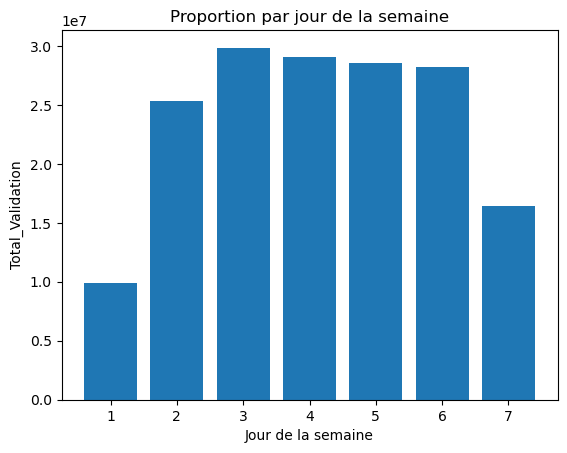

In [12]:


import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.window import Window
prop_df = (df1
            .withColumn('day_week', F.dayofweek('jour'))
            .groupby('day_week')
            .agg(F.sum('nb_vald').alias('Total_Validation'))
            .orderBy(F.desc('Total_Validation'))
            .withColumn('Proportion', F.round(F.col('Total_Validation')/F.sum('Total_Validation').over(Window.partitionBy())*100, 1))
         )
x = [row['day_week'] for row in prop_df.select('day_week').collect()]
y = [row['Total_Validation'] for row in prop_df.select('Total_Validation').collect()]
plt.bar(x, y, label='Proportion par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Total_Validation')
plt.title('Proportion par jour de la semaine')
plt.show()
